In [1]:
%load_ext autoreload
%autoreload 2
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from data_manager import *
from metrics import *
from models import *
from preprocessing import *


In [2]:
df_raw = get_train(dropNull=True)
df_train_raw, df_test_raw = split_by_date(df_raw, split_ratio=0.2)
df_raw.head()

data/optiver-trading-at-the-close/train.csv - loaded


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
row_id,,,,,,,,,,,,,,,,
0_0_0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.0,-3.029704,0
0_0_1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.0,-5.519986,0
0_0_2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.0,-8.389950,0
0_0_3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.0,-4.010200,0
0_0_4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.0,-7.349849,0


In [3]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

cols = [
    'stock_id',
    'seconds_in_bucket',
    'reference_price',
    'matched_size',
    'bid_price',
    'bid_size',
    'ask_price',
    'ask_size',
    'wap',
    'imbalance_size_rel',
]

models_dict = {
    'model null' :(Model_base(), Preprocessing_null()),
    'model baseline':(Imbalanced(), Preprocessing_null()),
    'model baseline linReg':(Sklearn(LinearRegression()), RestrictCols(['imbalance_buy_sell_flag'])),
    'model linReg +':(
        Sklearn(LinearRegression()), 
        ChainPrepro((
            Preprocessing_base(),
            RestrictCols(cols)))),
}
alphas = [round(10**(alpha/3)*0.001,4) for alpha in range(0,13)]
lasso_dict = {f'Lasso_{a}': (
    Sklearn(Lasso(a)),
    ChainPrepro((
        Preprocessing_base(),
        RestrictCols(cols)))
    ) for a in alphas}

Ridge_dict = {f'Ridge_{a}': (
    Sklearn(Lasso(a)),
    ChainPrepro((
        Preprocessing_base(),
        RestrictCols(cols)))
    ) for a in alphas}

models_dict = {**models_dict,**lasso_dict, **Ridge_dict}

score=[]
data_res=[]
for name, pipe in tqdm(models_dict.items()):
    print(name)
    model, preprocess = pipe
    df_res_train, df_res_test, mae_train, mae_test = train_test_score_fast(df_train_raw, df_test_raw, model=model, preprocess=preprocess)
    score.append((name, mae_train, mae_test))
    data_res.append((name, df_res_train, df_res_test))


model null
model baseline
model baseline linReg
model linReg +
Lasso_0.001
Lasso_0.0022


KeyboardInterrupt: 

,score_train,score_test
model linReg +,6.495051,6.059715
model baseline,6.494700,6.059927
model null,6.495554,6.060085
model baseline linReg,6.494479,6.060640


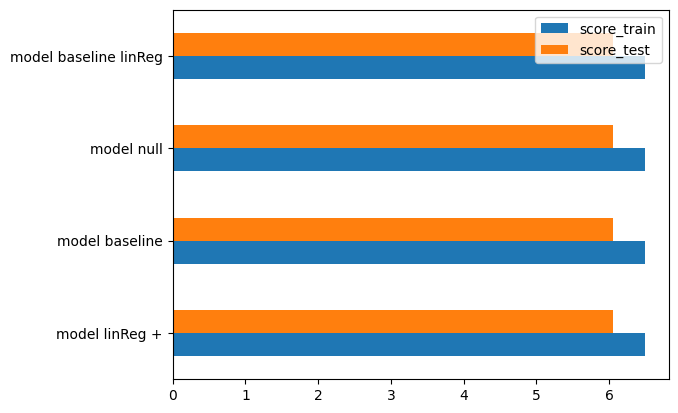

In [ ]:
name, score_train, score_test = zip(*score)
df_score = pd.DataFrame({
    'score_train':score_train,
    'score_test':score_test}, index = name
)

df_score.sort_values(by='score_test',inplace=True)
df_score.plot.barh()
display(df_score)